<a href="https://colab.research.google.com/github/pritesh-Sonar/-Coding-Raja-Technologies-Internship-/blob/main/Food_image_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Start

In [1]:
from google.colab import  drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Thu Jan 11 17:53:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [12]:
image_dir = '/content/drive/MyDrive/food image/images'

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

# Creating File Dataframe

In [14]:
image_dir = Path(image_dir)
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [15]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/food image/images/sashi...,sashimi
1,/content/drive/MyDrive/food image/images/risot...,risotto
2,/content/drive/MyDrive/food image/images/waffl...,waffles
3,/content/drive/MyDrive/food image/images/risot...,risotto
4,/content/drive/MyDrive/food image/images/prime...,prime_rib
...,...,...
2195,/content/drive/MyDrive/food image/images/ravio...,ravioli
2196,/content/drive/MyDrive/food image/images/ravio...,ravioli
2197,/content/drive/MyDrive/food image/images/spagh...,spaghetti_carbonara
2198,/content/drive/MyDrive/food image/images/takoy...,takoyaki


In [16]:
image_df['Label'].value_counts()

sashimi                 100
risotto                 100
spring_rolls            100
tiramisu                100
tuna_tartare            100
pulled_pork_sandwich    100
spaghetti_bolognese     100
scallops                100
steak                   100
red_velvet_cake         100
spaghetti_carbonara     100
sushi                   100
seaweed_salad           100
ramen                   100
tacos                   100
ravioli                 100
strawberry_shortcake    100
shrimp_and_grits        100
samosa                  100
prime_rib               100
waffles                 100
takoyaki                100
Name: Label, dtype: int64

# Train-Test Split

In [17]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [18]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [19]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1232 validated image filenames belonging to 22 classes.
Found 308 validated image filenames belonging to 22 classes.
Found 660 validated image filenames belonging to 22 classes.


# Modeling

In [20]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [25]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(22, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

# Training

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
39/39 [==============================] - 1030s 27s/step - loss: 2.4584 - accuracy: 0.3157 - val_loss: 1.8385 - val_accuracy: 0.4903
Epoch 2/100
39/39 [==============================] - 7s 187ms/step - loss: 1.2285 - accuracy: 0.6477 - val_loss: 1.4663 - val_accuracy: 0.5519
Epoch 3/100
39/39 [==============================] - 6s 164ms/step - loss: 0.7658 - accuracy: 0.7630 - val_loss: 1.4149 - val_accuracy: 0.5844
Epoch 4/100
39/39 [==============================] - 8s 202ms/step - loss: 0.4883 - accuracy: 0.8709 - val_loss: 1.3380 - val_accuracy: 0.5974
Epoch 5/100
39/39 [==============================] - 6s 161ms/step - loss: 0.3240 - accuracy: 0.9343 - val_loss: 1.4929 - val_accuracy: 0.5942
Epoch 6/100
39/39 [==============================] - 7s 177ms/step - loss: 0.2048 - accuracy: 0.9659 - val_loss: 1.4403 - val_accuracy: 0.5974
Epoch 7/100
39/39 [==============================] - 6s 163ms/step - loss: 0.1115 - accuracy: 0.9927 - val_loss: 1.5045 - val_accuracy: 0.613

# Results

In [27]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 60.45%


In [28]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

21/21 [==============================] - 6s 124ms/step


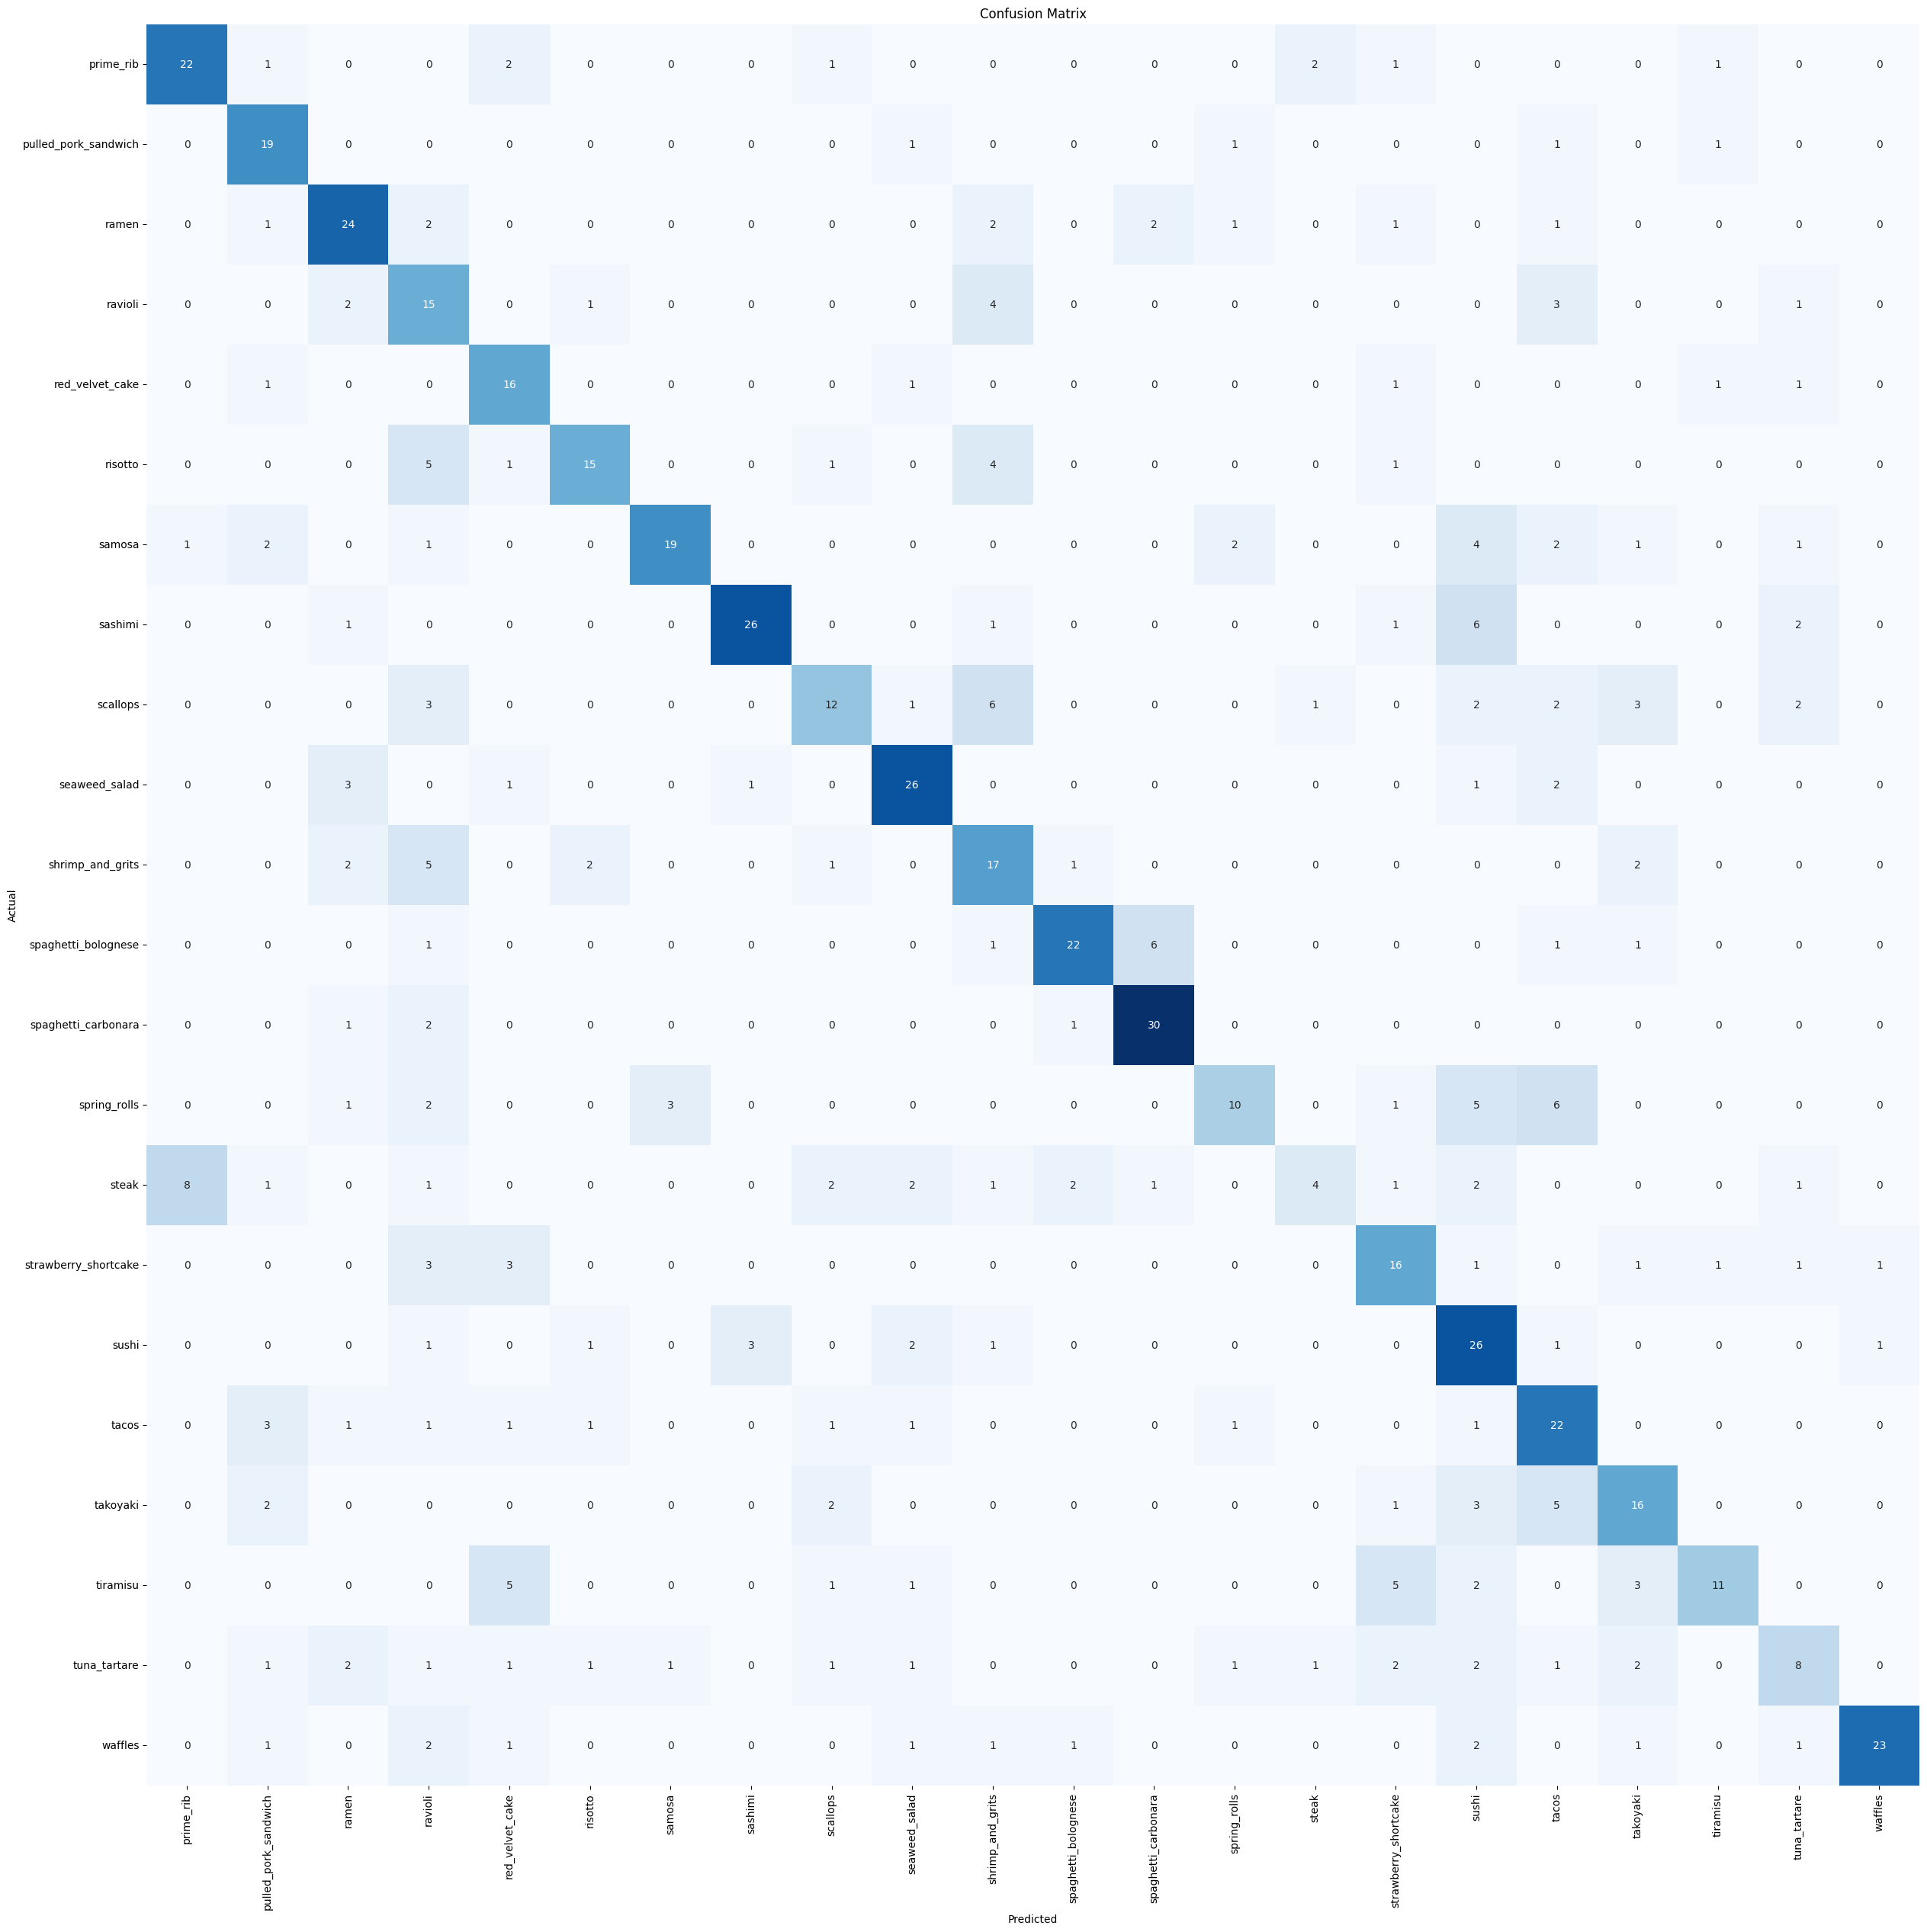

In [41]:

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(22) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(22) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [42]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                       precision    recall  f1-score   support

           prime_rib       0.71      0.73      0.72        30
pulled_pork_sandwich       0.59      0.83      0.69        23
               ramen       0.65      0.71      0.68        34
             ravioli       0.33      0.58      0.42        26
     red_velvet_cake       0.52      0.76      0.62        21
             risotto       0.71      0.56      0.63        27
              samosa       0.83      0.58      0.68        33
             sashimi       0.87      0.70      0.78        37
            scallops       0.55      0.38      0.44        32
       seaweed_salad       0.70      0.76      0.73        34
    shrimp_and_grits       0.45      0.57      0.50        30
 spaghetti_bolognese       0.81      0.69      0.75        32
 spaghetti_carbonara       0.77      0.88      0.82        34
        spring_rolls       0.62      0.36      0.45        28
               steak  